### **Explainable AI (XAI) with SHAP: Fairness analysis for GBM models**

This notebook trains a **Gradient Boosting Machine (GBM)**  model, interprets it using **SHAP** (SHapley Additive exPlanations), and audits fairness using both statistical analysis and fairlearn.

In [24]:
#install libraries
!pip install shap xgboost scikit-learn matplotlib seaborn fairlearn aequitas

In [2]:
#import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from fairlearn.metrics import MetricFrame
from aequitas import Audit


In [3]:
# Create and simulate a realistic dataset

np.random.seed(42)
n = 1000  # Number of samples

# Simulate features
income = np.random.normal(50000, 15000, n)
age = np.random.normal(40, 10, n)
credit_score = np.random.normal(700, 50, n)
zip_code = np.random.choice([10001, 20002, 30003, 40004], size=n)

# Simulate target variable (loan approval)
loan_approved = (np.random.rand(n) < 0.7).astype(int)

# Simulate sensitive features: Gender, Race, and Income Quartiles
gender = np.random.randint(0, 2, n)
race = np.random.choice([0, 1, 2, 3, 4], n)
income_quartile = pd.qcut(income, q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# Create DataFrame
data = pd.DataFrame({
    'income': income,
    'age': age,
    'credit_score': credit_score,
    'zip_code': zip_code,
    'loan_approved': loan_approved,
    'gender': gender,
    'race': race,
    'income_quartile': income_quartile
})

# Create labels for gender and race
data['gender_label'] = data['gender'].map({0: 'Female', 1: 'Male'})
race_map = {0: 'White', 1: 'Black', 2: 'Hispanic', 3: 'Asian', 4: 'Other'}
data['race_label'] = data['race'].map(race_map)

# Split into features and target
X = data.drop(columns=['loan_approved'])
y = data['loan_approved']


In [9]:
# Make sure categorical columns are set correctly
X['income_quartile'] = X['income_quartile'].astype('category')
X['gender_label'] = X['gender_label'].astype('category')
X['race_label'] = X['race_label'].astype('category')

# Make sure categorical columns are set correctly
X['income_quartile'] = X['income_quartile'].astype('category')
X['gender_label'] = X['gender_label'].astype('category')
X['race_label'] = X['race_label'].astype('category')

# Use the full feature set with categorical support
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Enable categorical handling in XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [10]:
# Predictions
y_pred = model.predict(X_test)


In [11]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.32      0.34        59
           1       0.73      0.76      0.74       141

    accuracy                           0.63       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.62      0.63      0.62       200



**SHAP Explanations**

<ipython-input-13-b00a5c33f594>:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


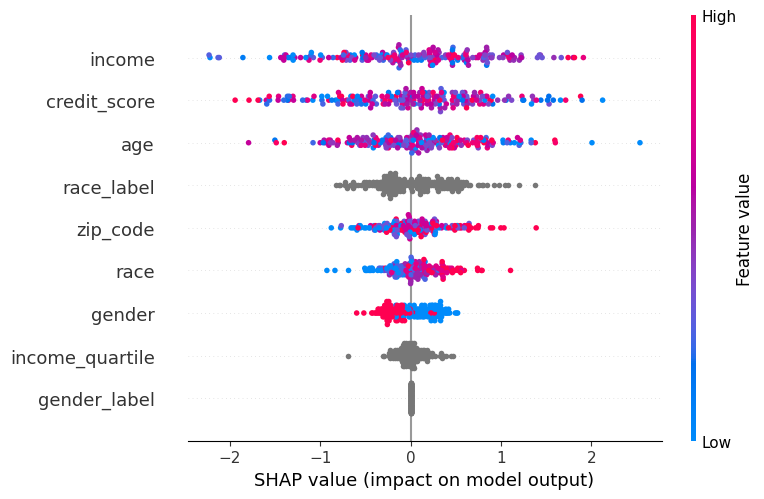

In [13]:
# SHAP Explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualize SHAP summary plot for global feature importance
shap.summary_plot(shap_values, X_test)



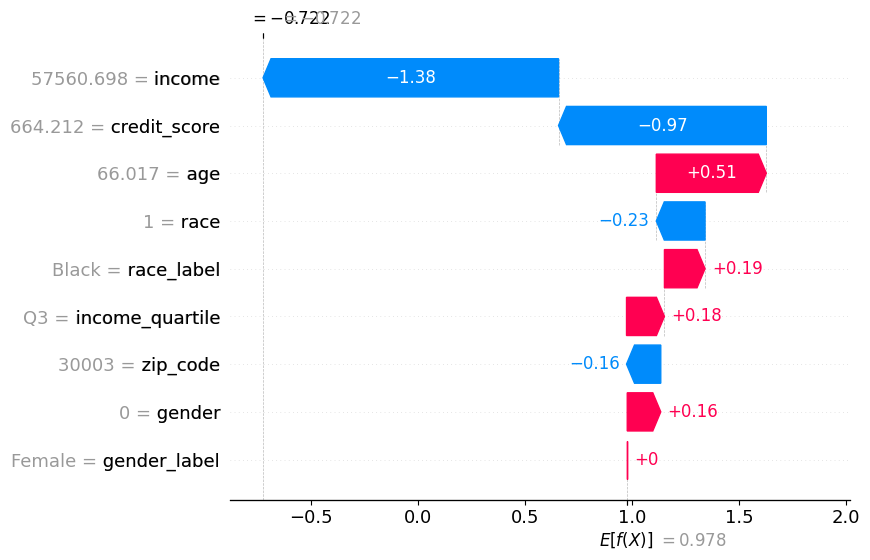

In [14]:
# Waterfall plot for a single prediction
shap.plots.waterfall(shap_values[0])

**Fairness Audit - Group Analysis**

In [15]:
# Compute approval rate by groups (gender, race, income_quartiles)
def approval_rate_by_group(data, group_col):
    return data.groupby(group_col)['loan_approved'].mean().reset_index().rename(columns={'loan_approved': 'approval_rate'})

# Fairness analysis: Disparate Impact (DI) calculation
def disparate_impact(data, group_col, ref_group):
    rates = approval_rate_by_group(data, group_col).set_index(group_col)
    reference_rate = rates.loc[ref_group, 'approval_rate']
    rates['disparate_impact'] = rates['approval_rate'] / reference_rate
    return rates

# Gender, Race, and Income Quartile audits
gender_bias = disparate_impact(data, 'gender_label', 'Female')
race_bias = disparate_impact(data, 'race_label', 'White')
income_bias = disparate_impact(data, 'income_quartile', 'Q4')

# Display results
print("Disparate Impact by Gender (Ref: Female):\n", gender_bias)
print("\nDisparate Impact by Race (Ref: White):\n", race_bias)
print("\nDisparate Impact by Income Quartile (Ref: Q4):\n", income_bias)

Disparate Impact by Gender (Ref: Female):
               approval_rate  disparate_impact
gender_label                                 
Female             0.718812          1.000000
Male               0.688889          0.958372

Disparate Impact by Race (Ref: White):
             approval_rate  disparate_impact
race_label                                 
Asian            0.703704          1.013134
Black            0.690141          0.993607
Hispanic         0.666667          0.959811
Other            0.769634          1.108054
White            0.694581          1.000000

Disparate Impact by Income Quartile (Ref: Q4):
                  approval_rate  disparate_impact
income_quartile                                 
Q1                       0.648          0.880435
Q2                       0.744          1.010870
Q3                       0.688          0.934783
Q4                       0.736          1.000000


<ipython-input-15-29a4a8751805>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return data.groupby(group_col)['loan_approved'].mean().reset_index().rename(columns={'loan_approved': 'approval_rate'})


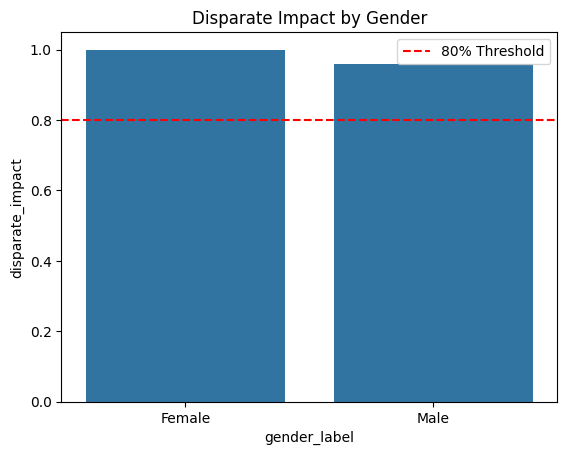

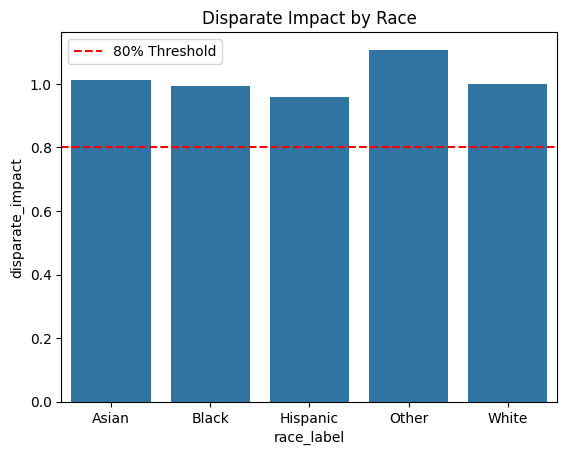

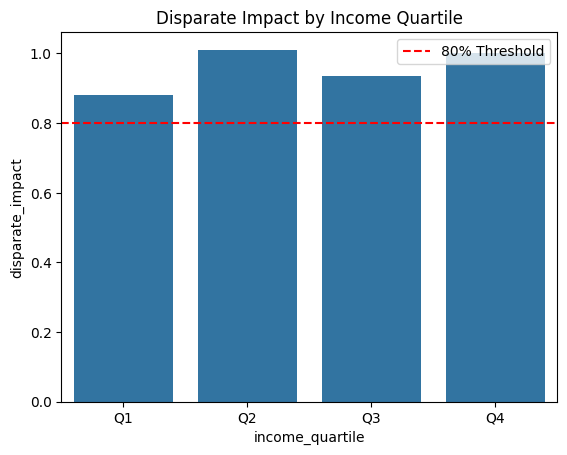

In [16]:
# Visualizing fairness audits (disparate impact)
sns.barplot(data=gender_bias.reset_index(), x='gender_label', y='disparate_impact')
plt.axhline(0.8, color='r', linestyle='--', label='80% Threshold')
plt.title("Disparate Impact by Gender")
plt.legend()
plt.show()

sns.barplot(data=race_bias.reset_index(), x='race_label', y='disparate_impact')
plt.axhline(0.8, color='r', linestyle='--', label='80% Threshold')
plt.title("Disparate Impact by Race")
plt.legend()
plt.show()

sns.barplot(data=income_bias.reset_index(), x='income_quartile', y='disparate_impact')
plt.axhline(0.8, color='r', linestyle='--', label='80% Threshold')
plt.title("Disparate Impact by Income Quartile")
plt.legend()
plt.show()

**Using Fairlearn**

In [19]:
from sklearn.metrics import accuracy_score

# Using Fairlearn to calculate fairness metrics by gender
sensitive_features = X_test['gender_label']
y_pred = model.predict(X_test)

# Fairness metrics calculation
metric_frame = MetricFrame(metrics={'accuracy': accuracy_score}, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features)

# Display fairness by group
print(metric_frame.by_group)

              accuracy
gender_label          
Female        0.640777
Male          0.618557


Next step, to understand how different features impact different groups and whether any group is disproportionately influenced by certain features - integrate SHAP values per group (e.g., by gender or race) and analyze whether certain features contribute more heavily to outcomes for different subgroups:

In [22]:
# Combine SHAP values and sensitive features for group-based SHAP summary
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

# Add sensitive features (gender, race, income_quartile) from X_test
shap_df['gender_label'] = X_test['gender_label'].values
shap_df['race_label'] = X_test['race_label'].values
shap_df['income_quartile'] = X_test['income_quartile'].values

# Ensure you are using only numeric columns for SHAP analysis
# Extract just the numeric feature columns (SHAP values) to avoid including categorical columns.
numeric_features = shap_df.columns.difference(['gender_label', 'race_label', 'income_quartile'])

# Grouped SHAP summary: average absolute SHAP values by group
def grouped_shap_summary(df, group_col, feature_cols):
    # Group by the sensitive feature (group_col) and compute the mean absolute SHAP values
    group_summary = df.groupby(group_col)[feature_cols].apply(lambda x: np.abs(x).mean())
    return group_summary.T  # Transpose for easier plotting (feature names as rows)

# Generate the SHAP summary for each group (gender, race, income quartile)
gender_shap_summary = grouped_shap_summary(shap_df, 'gender_label', numeric_features)
race_shap_summary = grouped_shap_summary(shap_df, 'race_label', numeric_features)
income_shap_summary = grouped_shap_summary(shap_df, 'income_quartile', numeric_features)


<ipython-input-22-e7c17bf2b4b0>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_summary = df.groupby(group_col)[feature_cols].apply(lambda x: np.abs(x).mean())
<ipython-input-22-e7c17bf2b4b0>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_summary = df.groupby(group_col)[feature_cols].apply(lambda x: np.abs(x).mean())
<ipython-input-22-e7c17bf2b4b0>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_

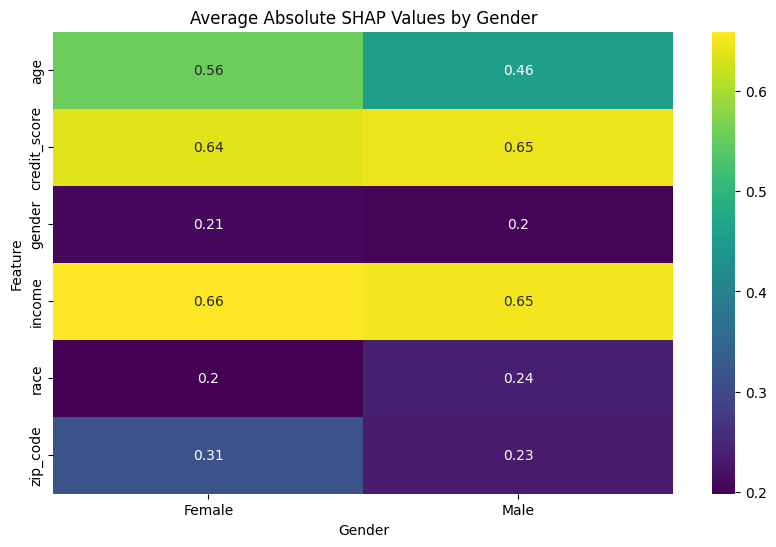

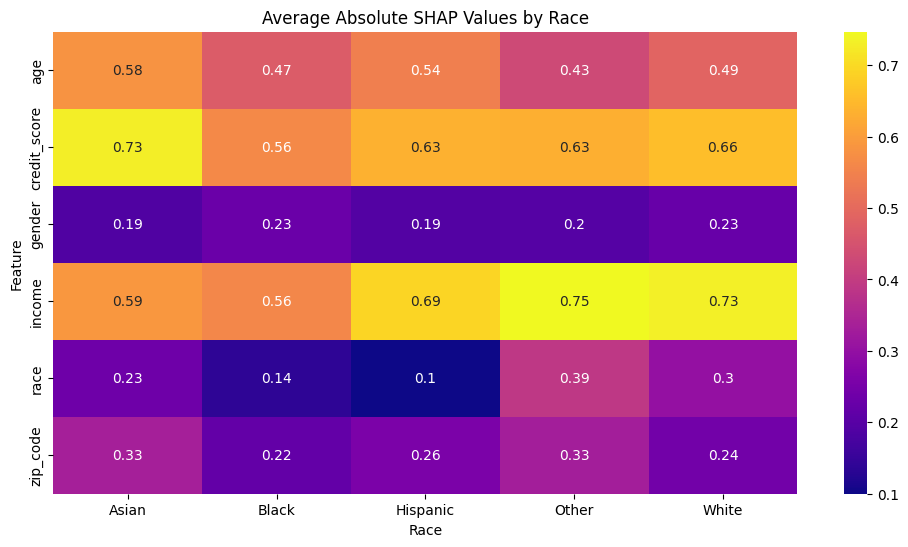

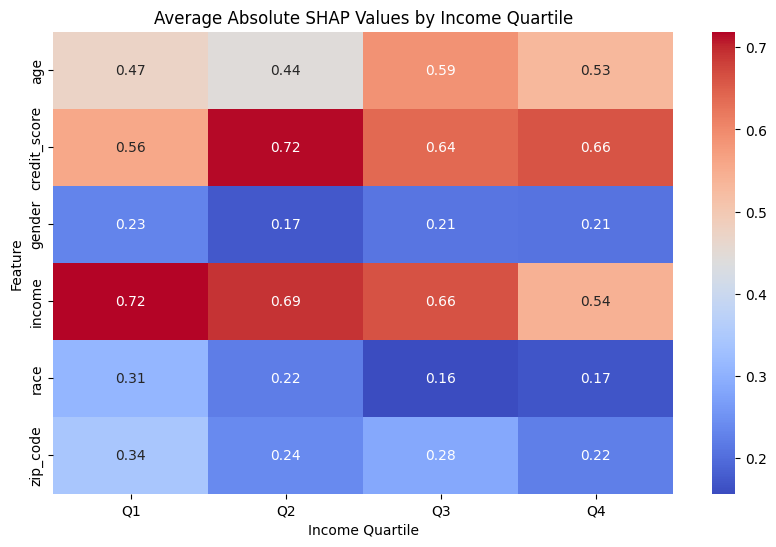

In [23]:

# Visualizing the grouped SHAP values by gender, race, income_quartile

# Gender SHAP Summary Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(gender_shap_summary, annot=True, cmap='viridis')
plt.title("Average Absolute SHAP Values by Gender")
plt.xlabel("Gender")
plt.ylabel("Feature")
plt.show()

# Race SHAP Summary Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(race_shap_summary, annot=True, cmap='plasma')
plt.title("Average Absolute SHAP Values by Race")
plt.xlabel("Race")
plt.ylabel("Feature")
plt.show()

# Income Quartile SHAP Summary Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(income_shap_summary, annot=True, cmap='coolwarm')
plt.title("Average Absolute SHAP Values by Income Quartile")
plt.xlabel("Income Quartile")
plt.ylabel("Feature")
plt.show()


**Heatmap reading:**

In a heatmap for each group (e.g., **gender**, **race**, **income quartile**), each row represents a **feature** (e.g., `income`, `age`, `credit_score`, etc.), and each column represents a **group** (e.g., `Male`, `Female`, `White`, `Black`, `Q1`, `Q2`, etc.).

**Heatmap color intensity** represents the **average absolute SHAP value** for that feature in that group.

- **Lighter colors (e.g., yellow or white)** indicate **higher feature importance** in making predictions for that group.
- **Darker colors (e.g., purple or blue)** indicate **lower feature importance** for that group.

In a **group-based SHAP heatmap**, you’ll be able to see which features are more influential in the model's predictions for each **group** that could help Identifying Potential Fairness Issues:**

For example, the **Race SHAP heatmap** suggests the model seems to **rely more heavily on `credit_score`** for **all races**. But this feature has a **higher impact for Asian** people (SHAP value = 0.73). Also, the feature **`zip_code`** appears to be slightly more influential for **Asians** individuals (SHAP value = 0.3). In this case, you might want to investigate further.


### Summary:

The purpose of combining **SHAP** with fairness analysis is to identify **disparities** in how the model uses features across different groups. If certain features disproportionately affect specific groups, it could indicate potential **bias** in the model.

Large discrepancies in SHAP values between groups suggest the model may not be equally fair, potentially favoring or disadvantaging certain groups.

In this case, for a GBM model, retraining the model might include **adjusting hyperparameters** e.g.,**tree depth**, **learning rate** to mitigate the bias, ensuring that the model treats all groups more equitably.
